## Predic the Forest Fires

- The data is a CSV file

The data is acquired from the following link:
    
- https://archive.ics.uci.edu/ml/datasets/forest+fires
    
Description of the data:
    
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

### Importing important libraries

In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')
%matplotlib inline

### Reading the dataset

In [16]:
dataset = pd.read_csv('forestfires.csv')
dataset.head()

X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

In [17]:
dataset.shape

(517, 13)

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [19]:
cat_data = dataset.select_dtypes('object').columns.to_list()
num_data = dataset.columns.to_list()
for col in cat_data:
    num_data.remove(col)
num_data.remove('area')
print('the categoraical columns in the dataset is: ', cat_data)
print('the numerical columns in the dataset is: ', num_data)

the categoraical columns in the dataset is:  ['month', 'day']
the numerical columns in the dataset is:  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


### Data preprocessing

In [20]:
## see if dataset containig null values
dataset.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [21]:
# see if the dataset containg duplicat values
dataset.duplicated().sum()

4

In [22]:
dataset[dataset.duplicated()]

X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
53   4  3   aug  wed  92.1  111.2  654.1   9.6  20.4  42   4.9   0.0   0.00
100  3  4   aug  sun  91.4  142.4  601.4  10.6  19.8  39   5.4   0.0   0.00
215  4  4   mar  sat  91.7   35.8   80.8   7.8  17.0  27   4.9   0.0  28.66
303  3  6   jun  fri  91.1   94.1  232.1   7.1  19.2  38   4.5   0.0   0.00

In [23]:
data_no_dup = dataset.copy()
data_no_dup.drop_duplicates(inplace = True)
data_no_dup[data_no_dup.duplicated()]

Empty DataFrame
Columns: [X, Y, month, day, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area]
Index: []

In [24]:
data_no_dup.describe()

X           Y        FFMC         DMC          DC         ISI  \
count  513.000000  513.000000  513.000000  513.000000  513.000000  513.000000   
mean     4.678363    4.300195   90.637427  110.989279  549.155166    9.023587   
std      2.320059    1.230925    5.540920   64.191013  247.724594    4.575543   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  440.900000    6.400000   
50%      4.000000    4.000000   91.600000  108.300000  664.500000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   11.000000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  513.000000  513.000000  513.000000  513.000000   513.000000  
mean    18.887524   44.348928    4.010526    0.021832    12.891598  
std      5.828128   16.358803    1.796613    0.297107    63.892586  
min      2.200000   15.000000    0.400000    0.000000     0.000000  
25%     15.500000   33.000000    2.700000    0.000000     0.000000  
50%     19.300000   42.000000    4.000000    0.000000     0.540000  
75%     22.800000   53.000000    4.900000    0.000000     6.570000  
max     33.300000  100.000000    9.400000    6.400000  1090.840000

In [25]:
data_no_dup.describe(include = ['object'])

month  day
count    513  513
unique    12    7
top      aug  sun
freq     182   94

- we need to transform the outcome 'area' by taking its logarithm (after adding 1 to avoid zeros)
- Log-arear = log10(area + 1)

In [26]:
data_no_dup['log-area'] = np.log10(data_no_dup['area'] + 1)

### Data visualization

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'FFMC'}>],
       [<AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>],
       [<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'log-area'}>]], dtype=object)

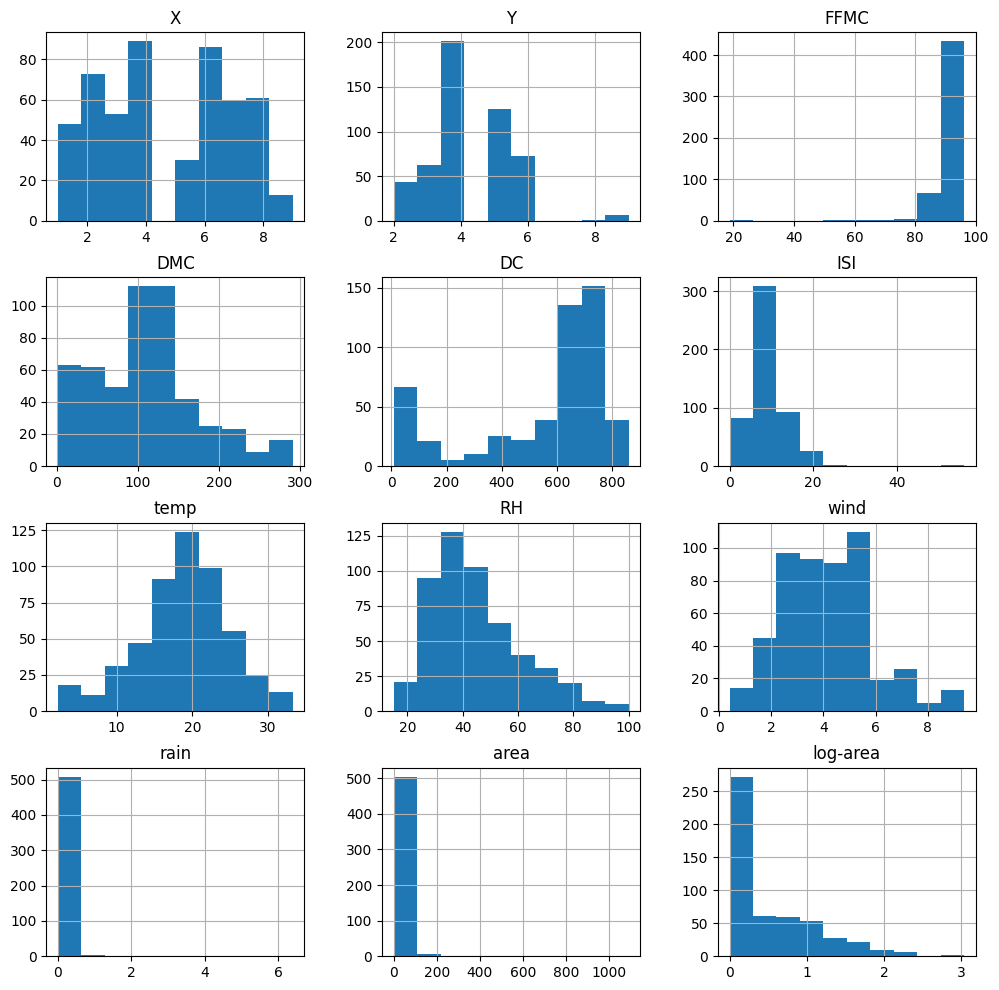

In [27]:
# display the histogram of all the columns
data_no_dup.hist(figsize = (12, 12))

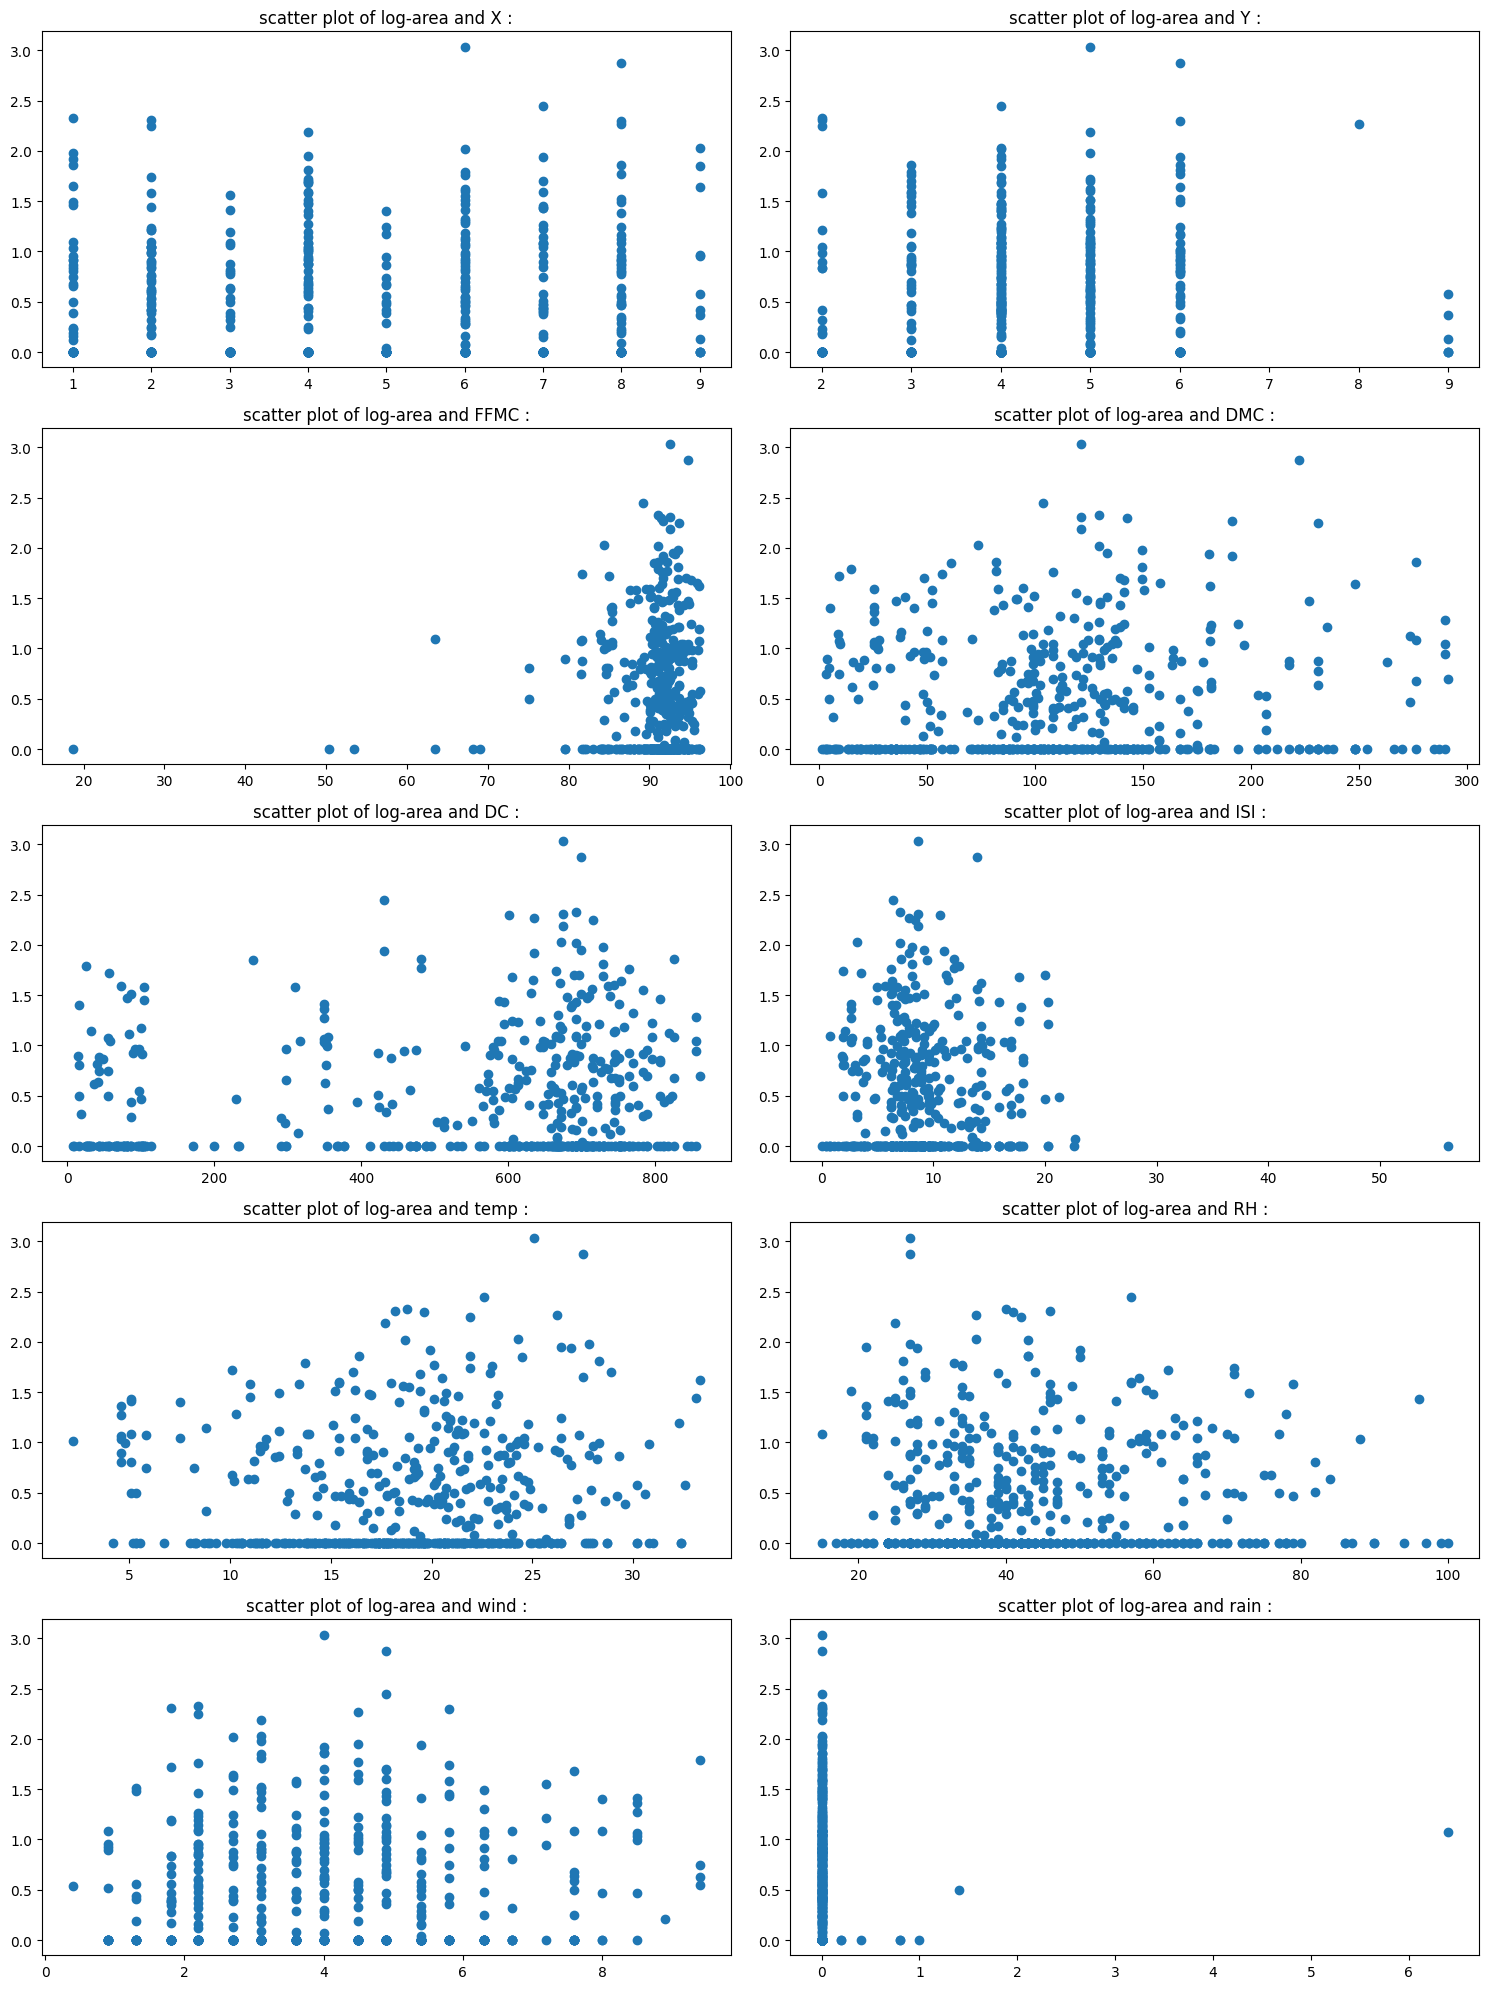

In [14]:
# DIsplay the scatter plot with x-axis as numerical columns and y-axis as log-area column
plt.figure(figsize = (15, 20))

for i, col in enumerate(data_no_dup[num_data].columns, 1):
    plt.subplot(5, 2, i)
    plt.title(f'scatter plot of log-area and {col} :')
    plt.scatter(data_no_dup[col], data_no_dup['log-area'])
    plt.tight_layout()

Text(0.5, 1.0, 'Correlation Heatmap')

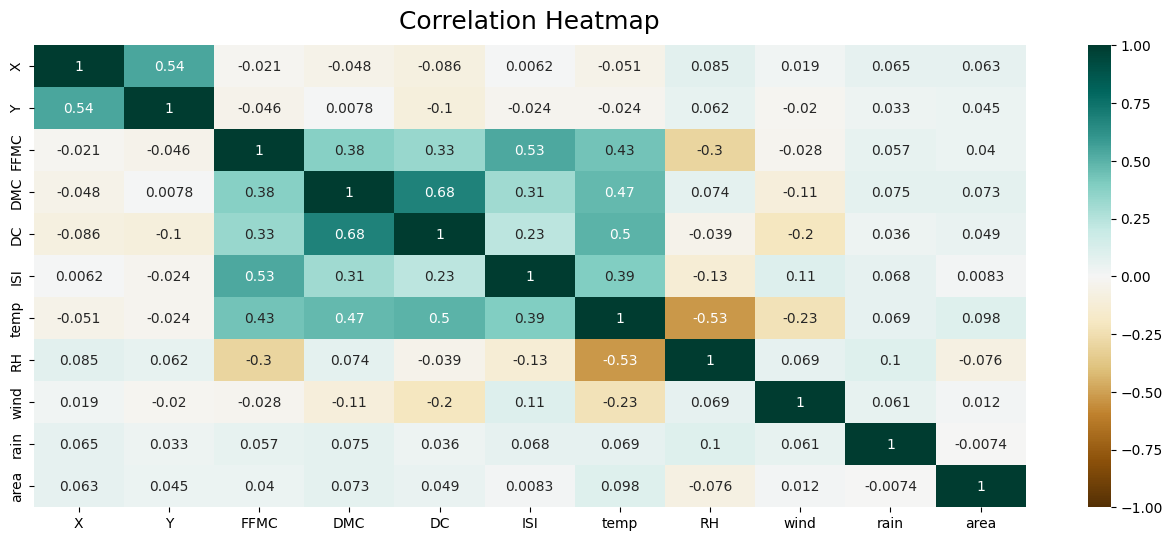

In [15]:
# correlation heatmap between features 
import seaborn as sns
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataset.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize': 18}, pad = 12)

<AxesSubplot:>

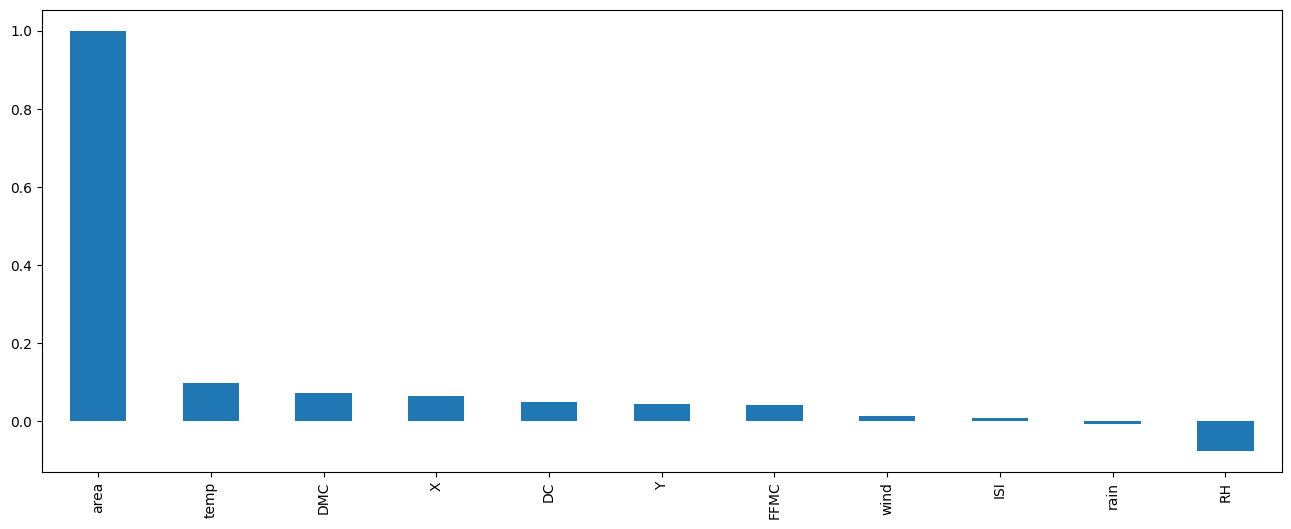

In [16]:
plt.figure(figsize = (16, 6))
dataset.corr()['area'].sort_values(ascending = False).plot(kind = 'bar')

#### univariate analysis

Skew: 12.802213419146321
Kurtosis: 192.73391233370953


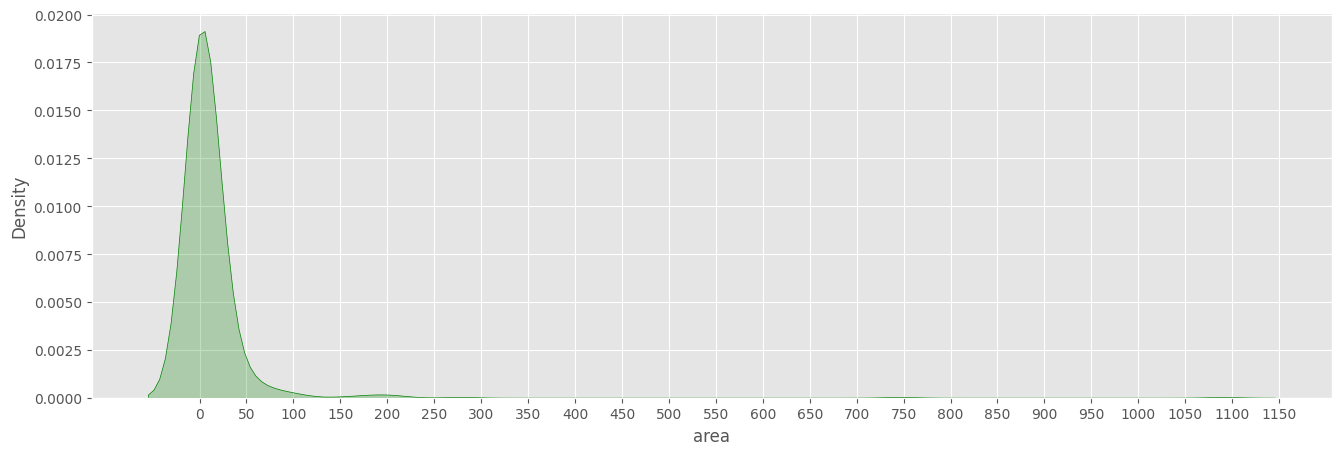

In [17]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = 9,5
plt.figure(figsize = (16, 5))
print("Skew: {}".format(data_no_dup['area'].skew()))
print("Kurtosis: {}".format(data_no_dup['area'].kurtosis()))
ax = sns.kdeplot(data_no_dup['area'],shade = True, color = 'g')
plt.xticks([i for i in range(0, 1200, 50)])
plt.show()

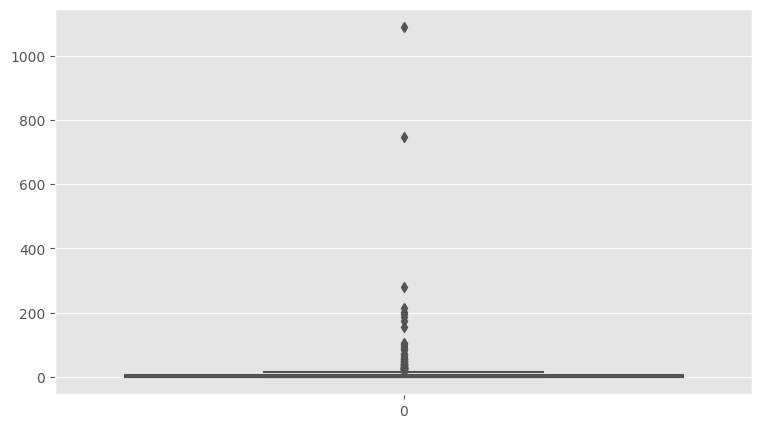

In [18]:
ax = sns.boxplot(data_no_dup['area'])

**Few observations:**

The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [28]:
from scipy.stats import zscore
y_outliers = data_no_dup[abs(zscore(data_no_dup['area'])) >= 3 ]
y_outliers

X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area  \
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88   
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84   
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28   
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53   

     log-area  
237  2.330170  
238  3.038159  
415  2.873483  
479  2.446428

#### analyzing categorical columns

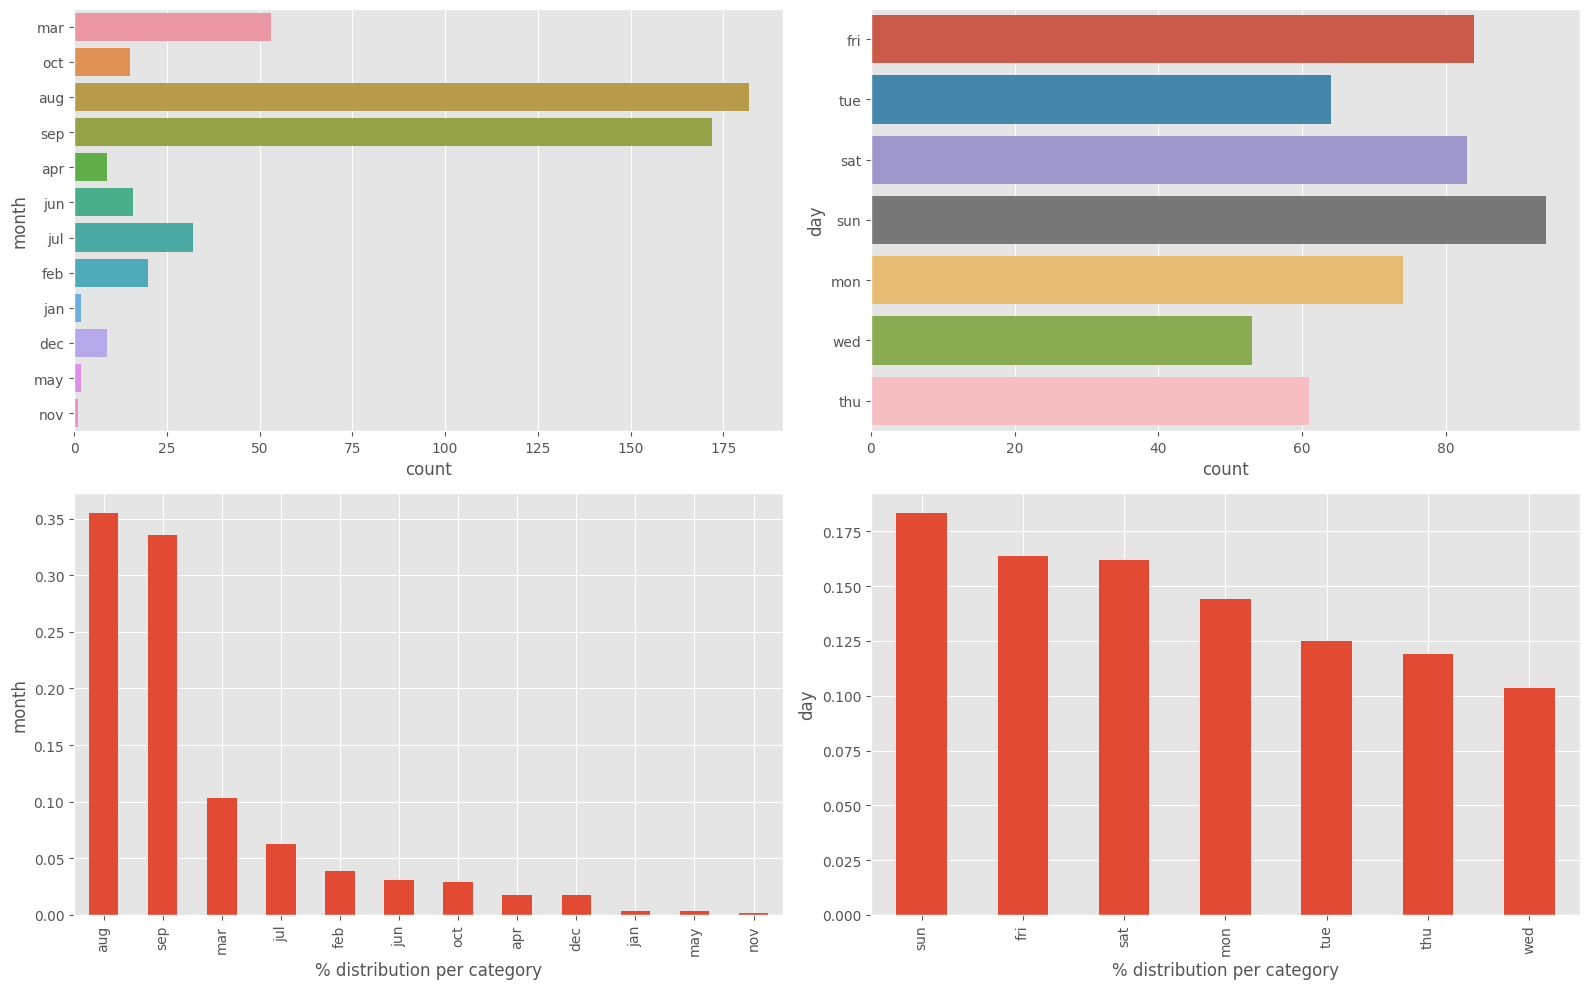

In [20]:
plt.figure(figsize = (16, 10))

for i,col in enumerate(cat_data, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data = data_no_dup.drop('area', axis = 1), y = col)
    plt.subplot(2, 2, i+2)
    data_no_dup[col].value_counts(normalize = True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')

plt.tight_layout()
plt.show()

- It is interesting to see that abnormally high number of the forest fires occur in the month of August and September.

- In the case of day, the days Friday to Monday have higher proportion of cases

#### analyzing numerical columns

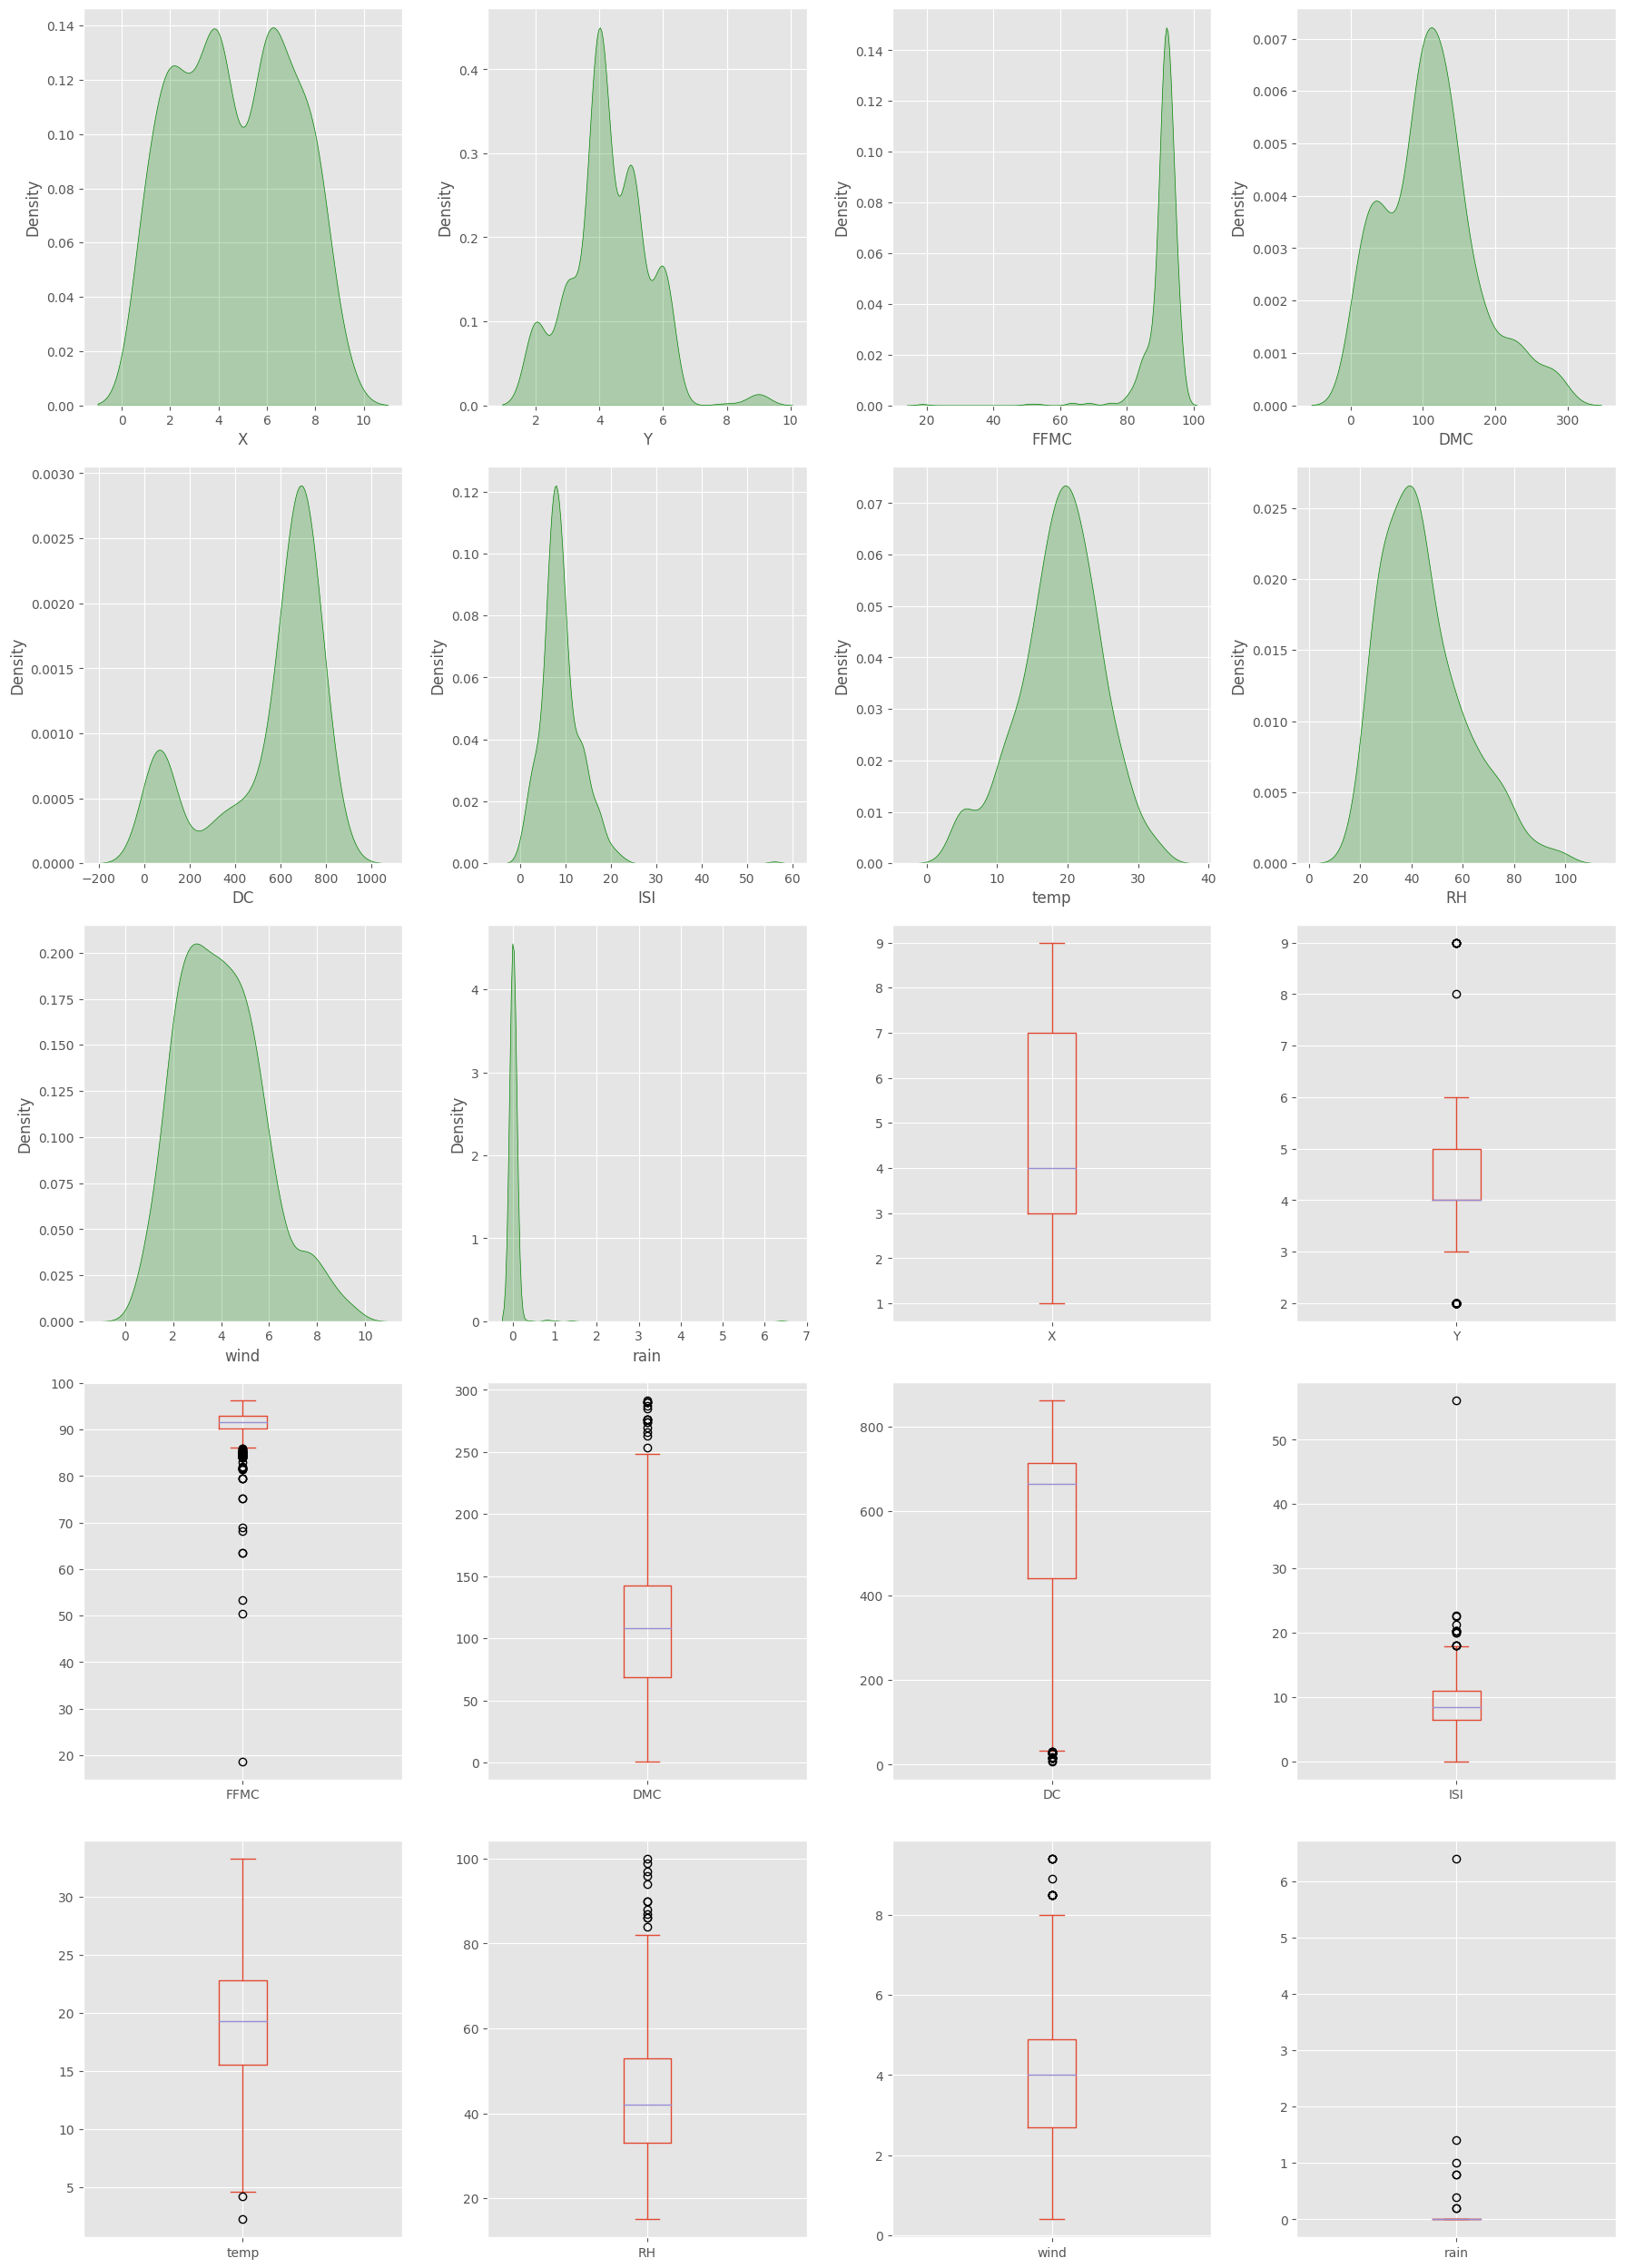

X         Y       FFMC       DMC        DC        ISI  \
skewness  0.025954  0.415768  -6.548903  0.545526 -1.111406   2.528218   
kurtosis -1.179535  1.430430  66.530072  0.193154 -0.216474  21.302313   

              temp        RH      wind        rain  
skewness -0.329215  0.854413  0.581191   19.739515  
kurtosis  0.113899  0.414890  0.052614  418.034830

In [21]:
plt.figure(figsize = (18, 40))

for i, col in enumerate(num_data, 1):
    plt.subplot(8, 4, i)
    sns.kdeplot(data_no_dup[col], color = 'g', shade = True)
    plt.subplot(8, 4, i + 10)
    data_no_dup[col].plot.box()

plt.tight_layout() 
plt.show()
nums = data_no_dup[num_data]
pd.DataFrame(data=[nums.skew(), nums.kurtosis()], index = ['skewness', 'kurtosis'])

**Outliers, Skewness and kurtosis (high positive or negative) was observed in the following columns:**

* 1- FFMC
* 2- ISI
* 3- rain

#### Bivariate analysis

In [29]:
print(data_no_dup['area'].describe(), '\n')
print(y_outliers)

count     513.000000
mean       12.891598
std        63.892586
min         0.000000
25%         0.000000
50%         0.540000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area  \
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88   
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84   
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28   
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53   

     log-area  
237  2.330170  
238  3.038159  
415  2.873483  
479  2.446428  


In [30]:
# categorical variable based on forest fire area damage
#(No damage), (low),(moderate), (high), (very high)

def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

data_no_dup['damage_category'] = data_no_dup['area'].apply(area_cat)
data_no_dup.sample(5)

X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area  \
313  6  5   sep  wed  92.6  115.4  777.1   8.8  24.3  27   4.9   0.0  0.00   
271  8  6   aug  tue  92.1  152.6  658.2  14.3  20.1  58   4.5   0.0  9.27   
390  7  4   feb  mon  84.7    9.5   58.3   4.1   7.5  71   6.3   0.0  9.96   
505  1  2   aug  thu  91.0  163.2  744.4  10.1  26.7  35   1.8   0.0  5.80   
107  4  5   aug  sun  90.2   99.6  631.2   6.3  21.4  33   3.1   0.0  0.00   

     log-area damage_category  
313  0.000000       No damage  
271  1.011570        moderate  
390  1.039811        moderate  
505  0.832509        moderate  
107  0.000000       No damage

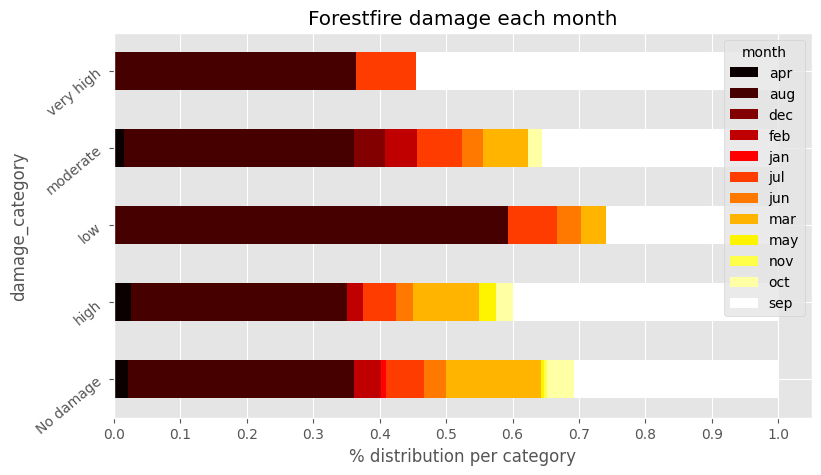

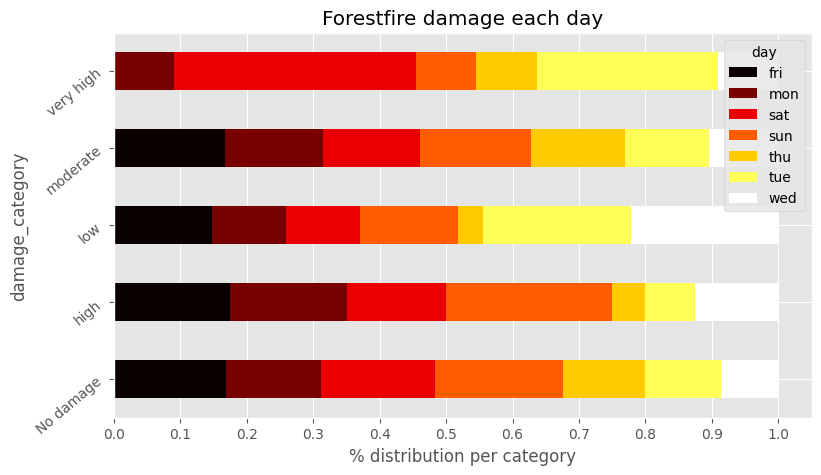

In [24]:
# categorical columns
for col in cat_data:
    cross = pd.crosstab(index = data_no_dup['damage_category'], columns = data_no_dup[col], normalize = 'index')
    cross.plot.barh(stacked = True,rot = 40,cmap = 'hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

- Previously we had observed that August and September had the most number of forest fires. And from the above plot of month, we can understand few things

    - Most of the fires in August were low (< 1 hectare).
    - The very high damages(>100 hectares) happened in only 3 months - august,july and september.
- Regarding fire damage per day, nothing much can be observed. Except that, there were no very high damaging fires on Friday and on Saturdays it has been reported most.

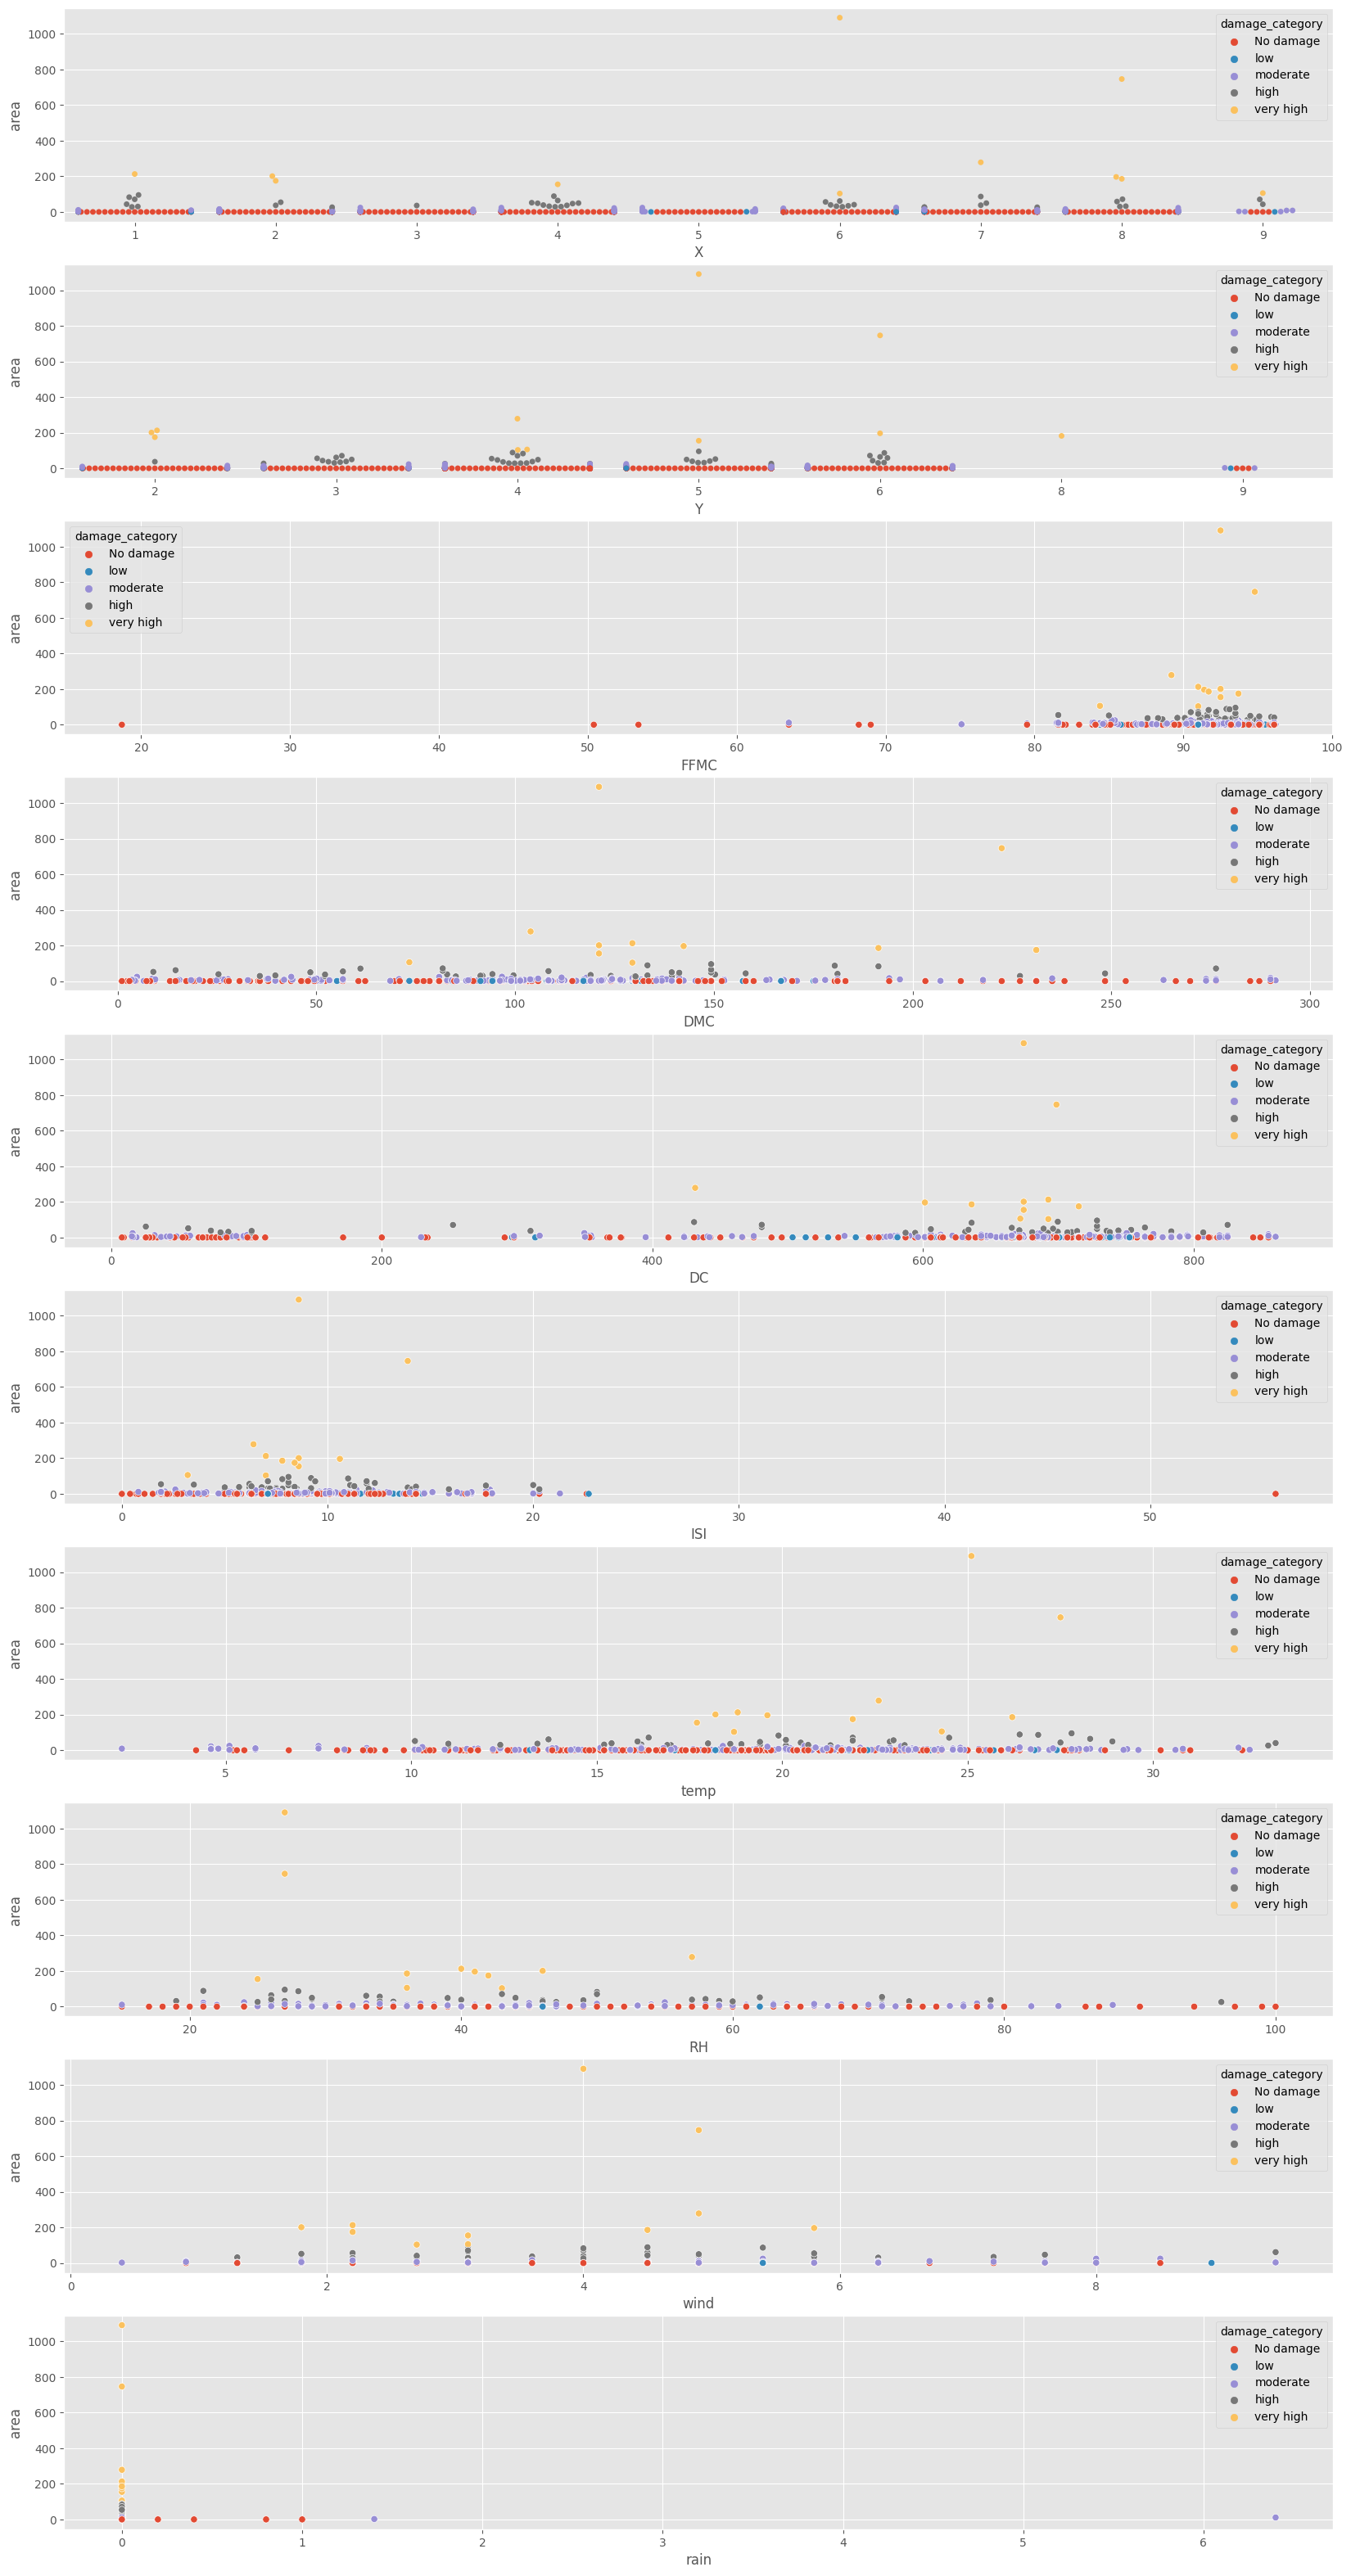

In [25]:
# numerical columns
plt.figure(figsize = (20, 40))
for i,col in enumerate(num_data, 1):
    plt.subplot(10, 1, i)
    if col in ['X', 'Y']:
        sns.swarmplot(data = data_no_dup, x = col, y = 'area', hue = 'damage_category')
    else:
        sns.scatterplot(data = data_no_dup, x = col,y = 'area',hue = 'damage_category')
plt.show()

#### multivariate analysis

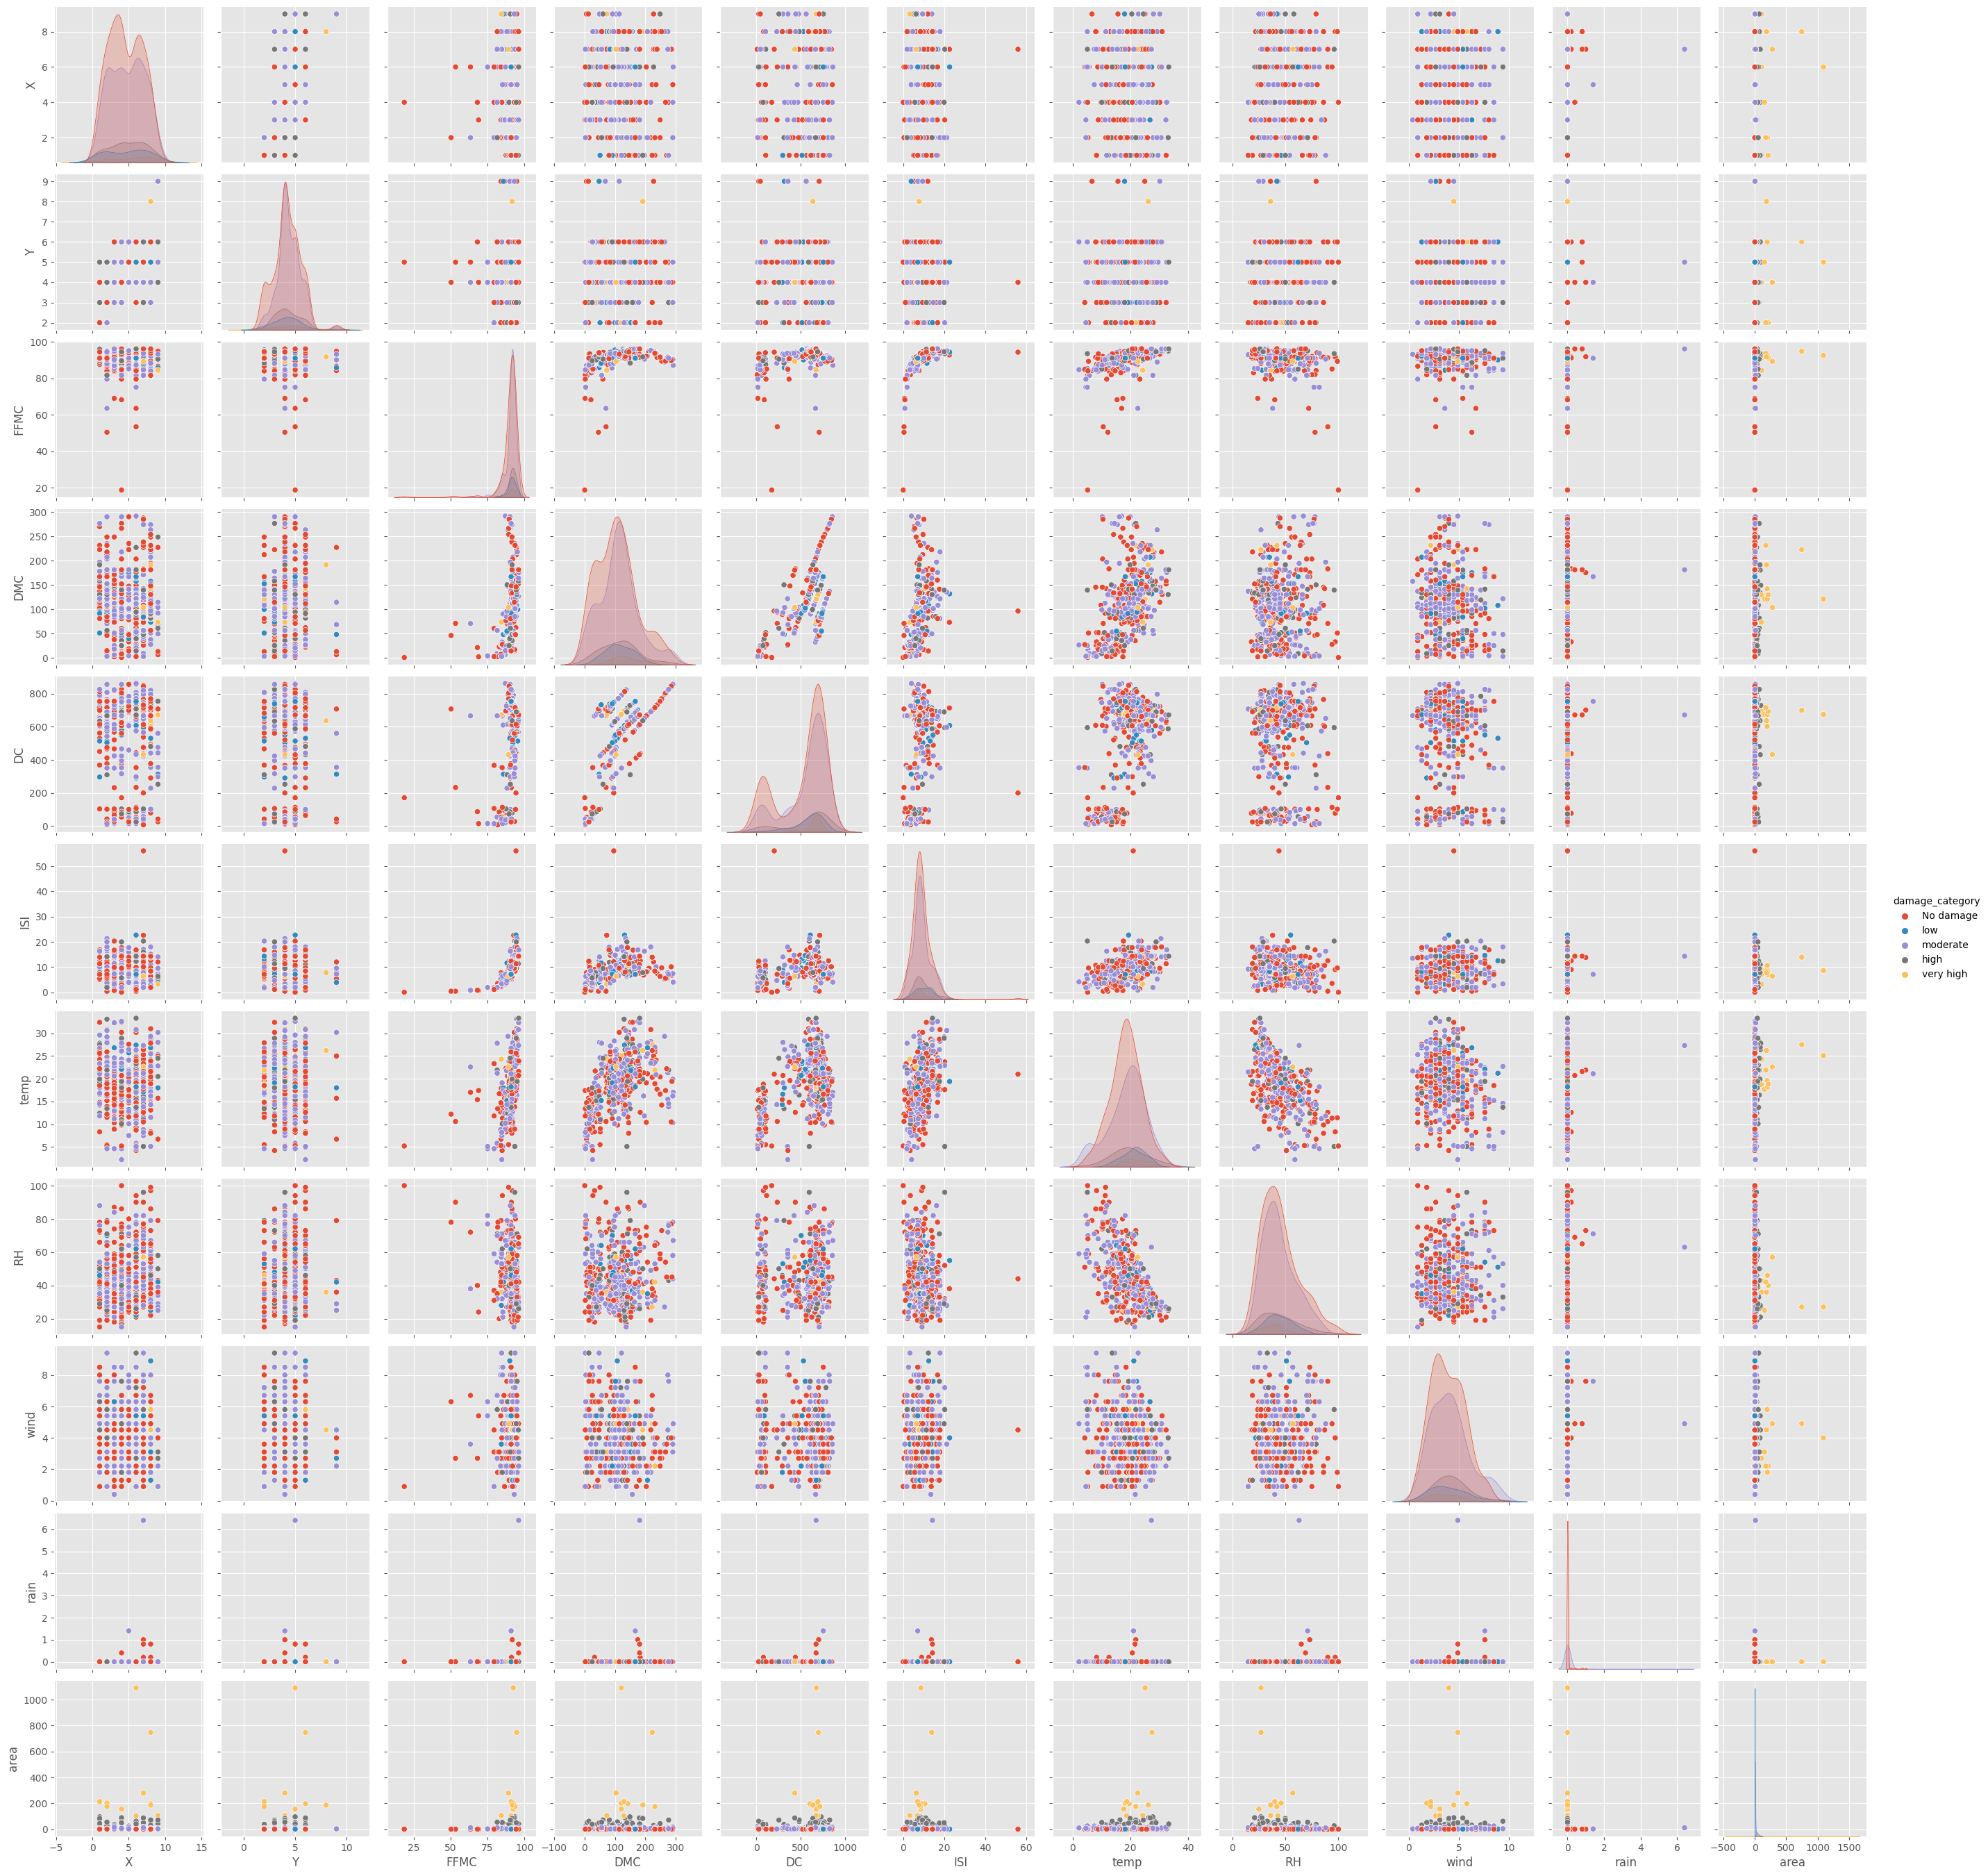

In [26]:
selected_features = data_no_dup.drop(columns = ['damage_category', 'day', 'month', 'log-area']).columns
sns.pairplot(data_no_dup, hue = 'damage_category', vars = selected_features)
plt.show()

### Outlier treatment

**We had observed outliers in the following columns:**

* 1- area
* 2- FFMC
* 3- ISI
* 4- rain
    - However, the above outliers are not error values so we cannot remove it.

    - In order to minimize the effect of outliers in our model we will transform the above features.

In [31]:
out_columns = ['area','FFMC','ISI','rain']
df = pd.get_dummies(data_no_dup, columns=['day','month'], drop_first = True)

print(np.log1p(df[out_columns]).skew())
print('-'*20)
print(np.log1p(df[out_columns]).kurtosis())

area     1.219398
FFMC   -11.630232
ISI     -0.931885
rain    14.117710
dtype: float64
--------------------
area      0.961880
FFMC    184.053886
ISI       2.546805
rain    232.413847
dtype: float64


In [32]:
# FFMC and rain are still having high skew and kurtosis values, 
# since we will be using Linear regression model we cannot operate with such high values
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:, ['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(506, 30)

In [33]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])
df[out_columns].skew()

area    1.210025
FFMC   -1.794148
ISI    -0.431279
dtype: float64

In [34]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns = ['damage_category']).copy()
df_ml.head()

X  Y      FFMC   DMC     DC       ISI  temp  RH  wind  rain  ...  \
0  7  5  4.468204  26.2   94.3  1.808289   8.2  51   6.7     0  ...   
1  7  4  4.517431  35.4  669.1  2.041220  18.0  33   0.9     0  ...   
2  7  4  4.517431  43.7  686.9  2.041220  14.6  33   1.3     0  ...   
3  8  6  4.529368  33.3   77.5  2.302585   8.3  97   4.0     1  ...   
4  8  6  4.503137  51.3  102.2  2.360854  11.4  99   1.8     0  ...   

   month_dec  month_feb  month_jan  month_jul  month_jun  month_mar  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          1   
4          0          0          0          0          0          1   

   month_may  month_nov  month_oct  month_sep  
0          0          0          0          0  
1          0          0          1          0  
2          0          0          1          0  
3          0          0          0          0  
4          0          0          0          0  

[5 rows x 29 columns]

### Model Building

In [31]:
inputs = df_ml.drop(['area', 'log-area'], axis = 1)
target = df_ml['log-area']
inputs.shape

(506, 27)

In [32]:
# split data into training set and testin set
from sklearn.model_selection import train_test_split
x_train , x_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.25, random_state = 42)
x_train.shape, x_test.shape

((379, 27), (127, 27))

In [75]:
# Defining REC (regression error charcteristics)
def rec(m, n, tol):     
    if type(m) != 'numpy.ndarray':
        m = np.array(m)
    if type(n) != 'numpy.ndarray':
        n = np.array(n)

    l = m.size       #Assigning m.size to l
    percent = 0
    for i in range(l):
        if np.abs(10 ** m[i] - 10 ** n[i]) <= tol:
            percent += 1
    return 100 * (percent / l)   

#### Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [5, 10, 15, 20, 50], 'max_leaf_nodes': [2, 5, 10], 'min_samples_leaf': [2, 5, 10],
    'min_samples_split':[2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid = params, refit = True, verbose = 0, cv = 5)
grid_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 50],
                         'max_leaf_nodes': [2, 5, 10],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [35]:
print("Best parameters obtained by Grid Search:",grid_rf.best_params_)  

Best parameters obtained by Grid Search: {'max_depth': 20, 'max_leaf_nodes': 2, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [36]:
from sklearn.metrics import mean_squared_error

a = grid_rf.predict(x_test)     
print("RMSE for Random Forest:",  np.sqrt(mean_squared_error(y_test, a)))    

RMSE for Random Forest: 0.6141520765105647


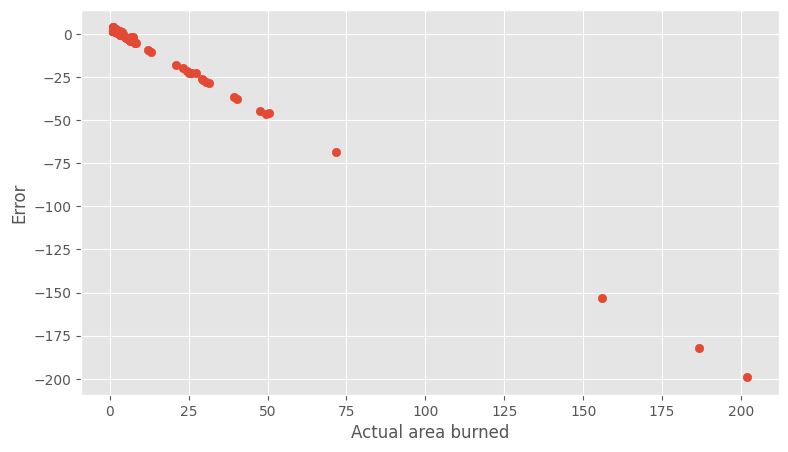

In [37]:
# Scatter plot to show actual area burned and error
plt.xlabel("Actual area burned")     
plt.ylabel("Error")          
plt.grid(True)    
plt.scatter(10 ** (y_test), 10 ** (a) - 10 ** (y_test))

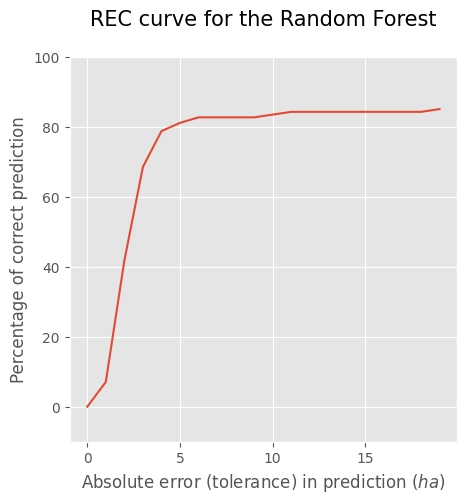

In [38]:
rec_RF=[]
for i in range(20):
    rec_RF.append(rec(a, y_test, i))

plt.figure(figsize=(5,5))   
plt.title("REC curve for the Random Forest\n",fontsize = 15)  
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")   
plt.ylabel("Percentage of correct prediction")   
plt.xticks([i for i in range(0, 20 + 1, 5)])
plt.ylim(-10, 100)    
plt.yticks([i * 20 for i in range(6)])
plt.grid(True)   
plt.plot(range(20), rec_RF)

#### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [40]:
y_pred = lm.predict(x_test)
print('RMSE for Linear Regression: ',np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE for Linear Regression:  0.6229282409096911


In [41]:
mean_squared_error(y_test, y_pred)

0.3880395933228422

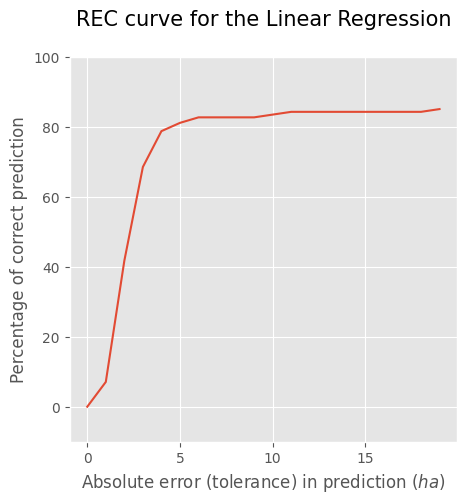

In [42]:
rec_lm=[]
for i in range(20):
    rec_lm.append(rec(y_pred, y_test, i))

plt.figure(figsize=(5 ,5))   
plt.title("REC curve for the Linear Regression\n",fontsize = 15)  
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")   
plt.ylabel("Percentage of correct prediction")   
plt.xticks([i for i in range(0, 20 + 1, 5)])
plt.ylim(-10, 100)    
plt.yticks([i * 20 for i in range(6)])
plt.grid(True)   
plt.plot(range(20), rec_RF)

#### Neural Network

In [61]:
# encode categorical data
data_for_model = data_no_dup.copy()
data_for_model['day'] = data_for_model['day'].map({'fri':1, 'tue':2, 'sat':3, 'sun':4, 'mon':5, 'wed':6, 'thu':7})
data_for_model['month'] = data_for_model['month'].map({'mar':1, 'oct':2, 'aug':3, 'sep':4, 'apr':5, 'jun':6, 'jul':7, 'feb':8, 'jan':9,
       'dec':10, 'may':11, 'nov':12})
data_for_model[['day', 'month']].sample(5)

day  month
139    2      4
476    7      7
271    2      3
290    3      7
473    3      6

In [62]:
# we will use this dataframe for building our ML model
df_ml = data_for_model.drop(columns = ['damage_category']).copy()
df_ml.head()

X  Y  month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5      1    1  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4      2    2  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4      2    3  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6      1    1  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6      1    4  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   log-area  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [63]:
inputs = df_ml.drop(['area', 'log-area'], axis = 1)
target = df_ml['log-area']
inputs.shape

(513, 12)

In [64]:
# split data into training set and testin set
from sklearn.model_selection import train_test_split
x_train , x_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape

((410, 12), (103, 12))

In [65]:
# scale the data using (standard scaler)
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [63]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras

In [68]:
tf.random.set_seed(42)

# create model
model = Sequential([
    keras.layers.Dense(200, input_dim = 12, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation = 'relu'),
    keras.layers.Dense(1)
])

# compile model
model.compile(optimizer = keras.optimizers.Adam(.01), loss = keras.losses.mse)

# fit model
history = model.fit(x_train, y_train, epochs = 200, batch_size = 12)

Epoch 1/200
35/35 [==============================] - 1s 2ms/step - loss: 0.8425
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 0.5184
Epoch 3/200
35/35 [==============================] - 0s 4ms/step - loss: 0.4697
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 0.4189
Epoch 5/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3983
Epoch 6/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3926
Epoch 7/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3830
Epoch 8/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3854
Epoch 9/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3794
Epoch 10/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3845
Epoch 11/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3729
Epoch 12/200
35/35 [==============================] - 0s 1ms/step - loss: 0.3731
Epoch 13/200
35/35 [=================

In [69]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.7223


0.7223018407821655

In [73]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, model.predict(x_test)))

4/4 [==============================] - 0s 1ms/step


0.8498834182760422

4/4 [==============================] - 0s 997us/step


4/4 [==============================] - 0s 1ms/step


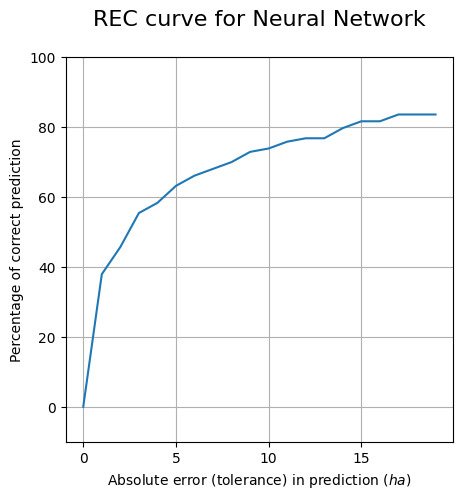

In [76]:
rec_NN=[]   
for i in range(20):
    rec_NN.append(rec(model.predict(x_test), y_test,i))
plt.figure(figsize=(5,5)) 
plt.title("REC curve for Neural Network\n",fontsize=16)  
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")   
plt.ylabel("Percentage of correct prediction")   
plt.xticks([i for i in range(0,20+1,5)]) 
plt.ylim(-10,100)  
plt.yticks([i*20 for i in range(6)])
plt.grid(True)   
plt.plot(range(20),rec_NN)

#### XGBoost

In [50]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, booster = 'gbtree',
                         verbosity = 0, nthread = -1,
                          random_state = 1337)
params = {
    'min_child_weight': [None, 1, 5, 10],
    'gamma': [None, 0.1, 1, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [1, 2, 3, 4, 5]
}
gs_xg = GridSearchCV(xgb_model , param_grid = params, n_jobs = -1, cv = 5, 
                  verbose = 0)
gs_xg.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0....
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [None, 0.1, 1, 5],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_child_weight': [None, 1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]})

In [51]:
gs_xg.best_params_

{'colsample_bytree': 0.8,
 'gamma': 5,
 'max_depth': 1,
 'min_child_weight': 10,
 'subsample': 0.6}

In [52]:
a = gs_xg.predict(x_test)     
print("RMSE for XGBoost:",  np.sqrt(mean_squared_error(y_test, a)))   

RMSE for XGBoost: 0.6138731128359269


#### Support vector machine

In [66]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
params = [
    {'C': np.arange(1.0, 10.0, 1.0),
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
    },
    {
    'C': np.arange(1.0, 10.0, 1.0),
    'kernel': ['linear', 'sigmoid'],
    }
]
gs_svc = GridSearchCV(SVR(),param_grid = params, n_jobs = -1, cv = 10, 
                  verbose = 0)
gs_svc.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
                         {'C': array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
                          'kernel': ['linear', 'sigmoid']}])

In [67]:
gs_svc.best_params_

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In [68]:
from sklearn.metrics import mean_squared_error
a = gs_svc.predict(x_test)     
print("RMSE for SVR:",  np.sqrt(mean_squared_error(y_test, a)))   

RMSE for SVR: 0.583281541548372


In [69]:
model = SVR(C =  1.0, gamma= 'scale', kernel= 'rbf')
model.fit(x_train, y_train)

SVR()

In [70]:
a = model.predict(x_test)     
print("RMSE for SVR:",  np.sqrt(mean_squared_error(y_test, a)))   

RMSE for SVR: 0.583281541548372


In [120]:
from sklearn.pipeline import make_pipeline
scaling = make_pipeline(scale)

In [122]:
import pickle
saved_model = pickle.dump(model, open('ForestModel.pickle','wb'))
scaled = pickle.dump(scaling, open('scalling.pickle','wb'))